In [1]:
import QuantLib as ql
import matplotlib.pyplot as plt
import datetime
import pandas as pd
import math
from nowquotes import download
from wmDownloader import getOptionsInfo,getHistoryQuotesInfo,getIndexQuotesInfo

%matplotlib inline

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
risk_free_rate = 0.03 #无风险利率 优化点1  0.005 利率差 对应期权0.1%价格波动，变化不大
dividend_rate =  0
day_count = ql.Actual365Fixed()  #一年的日期数 优化点2  

In [3]:
def calculateImpliedVolatility(option_price,spot_price,strike_price,calculation_date,maturity_date,option_type):
    volatility = 0
    calendar = ql.China() 
    payoff = ql.PlainVanillaPayoff(option_type, strike_price)  
    exercise = ql.EuropeanExercise(maturity_date) 
    european_option = ql.VanillaOption(payoff, exercise) 
    spot_handle = ql.QuoteHandle(  
        ql.SimpleQuote(spot_price)
    )
    flat_ts = ql.YieldTermStructureHandle( 
        ql.FlatForward(calculation_date, risk_free_rate, day_count)
    )  
    dividend_yield = ql.YieldTermStructureHandle(
        ql.FlatForward(calculation_date, dividend_rate, day_count)
    ) 
    flat_vol_ts = ql.BlackVolTermStructureHandle(
        ql.BlackConstantVol(calculation_date, calendar, volatility, day_count)  
    )
    bsm_process = ql.BlackScholesMertonProcess(spot_handle, 
                                               dividend_yield, 
                                               flat_ts, 
                                               flat_vol_ts)
    try:
        vol = european_option.impliedVolatility(option_price,bsm_process)
        return vol
    except Exception,e:
#         print e
        return float('nan')

In [4]:
options_info = getOptionsInfo(True)
options_info.head(3)

,contMultNum,contractStatus,contractType,currencyCD,deliDate,delistDate,exchangeCD,exerDate,expDate,expMonth,...,listDate,secID,secShortName,strikePrice,tickerSymbol,varExchangeCD,varSecID,varShortName,varTicker,varType
optID,,,,,,,,,,,,,,,,,,,,,
10000001,10000,DE,CO,CNY,2015-03-26,2015-03-25,XSHG,2015-03-25,2015-03-25,3,...,2015-02-09,510050C1503M02200.XSHG,50ETF购3月2200,2.20,510050C1503M02200,XSHG,510050.XSHG,华夏上证50ETF,510050,F
10000002,10000,DE,CO,CNY,2015-03-26,2015-03-25,XSHG,2015-03-25,2015-03-25,3,...,2015-02-09,510050C1503M02250.XSHG,50ETF购3月2250,2.25,510050C1503M02250,XSHG,510050.XSHG,华夏上证50ETF,510050,F
10000003,10000,DE,CO,CNY,2015-03-26,2015-03-25,XSHG,2015-03-25,2015-03-25,3,...,2015-02-09,510050C1503M02300.XSHG,50ETF购3月2300,2.30,510050C1503M02300,XSHG,510050.XSHG,华夏上证50ETF,510050,F


In [5]:
index_quotes_info = getIndexQuotesInfo(True)
index_quotes_info.head(3)

,CHG,CHGPct,accumAdjFactor,circulationShares,closePrice,discount,discountRatio,exchangeCD,highestPrice,lowestPrice,openPrice,preClosePrice,secID,secShortName,ticker,turnoverValue,turnoverVol
tradeDate,,,,,,,,,,,,,,,,,
2005-02-23,-0.011,-0.0124,1.0,5.940000e+09,0.876,0.002,0.002278,XSHG,0.882,0.866,0.881,0.887,510050.XSHG,华夏上证50ETF,510050,1111793167,1269742542
2005-02-24,0.000,0.0000,1.0,5.768000e+09,0.876,0.001,0.001140,XSHG,0.876,0.868,0.876,0.876,510050.XSHG,华夏上证50ETF,510050,394141216,451614223
2005-02-25,0.004,0.0046,1.0,5.509000e+09,0.880,-0.002,-0.002278,XSHG,0.887,0.875,0.877,0.876,510050.XSHG,华夏上证50ETF,510050,446597972,506460695


In [6]:
def getVolOfDay(day):
    daystr = day.strftime("%Y%m%d")
    try:
        calculation_date = ql.Date(day.day, day.month, day.year) #计算日
        ql.Settings.instance().evaluationDate = calculation_date
        df = getHistoryQuotesInfo(daystr,read_cache=True)
        index_price = index_quotes_info["closePrice"][day.strftime("%Y-%m-%d")]
        delta_se = pd.Series()
        vol_se = pd.Series()
        for i in range(-20,20):
            spot_price = index_price + float(i)/1000
            call_se = pd.Series()
            put_se = pd.Series()
            for index,row in df.iterrows():
                exer_date = options_info["exerDate"][index]
                exer_datetime = datetime.datetime.strptime(exer_date,"%Y-%m-%d")
                delta = exer_datetime - day
                if delta.days < 31:
                    maturity_date = ql.Date(exer_datetime.day, exer_datetime.month, exer_datetime.year) #交割日
                    contractType = options_info["contractType"][index] 
                    option_type = (ql.Option.Call if contractType == "CO" else ql.Option.Put)
                    strike_price = options_info["strikePrice"][index] 
                    price = row["closePrice"]
                    vol = calculateImpliedVolatility(price,spot_price,strike_price,calculation_date,maturity_date,option_type)
                    if math.isnan(vol):
    #                     print spot_price,index_price,calculation_date,maturity_date,contractType,strike_price,price
                        continue
                    if contractType == "CO":
                        call_se[strike_price] = vol
                    else:
                        put_se[strike_price] = vol
            if len(call_se) == 0:
                continue
            call_se = call_se.sort_index(inplace=False)
            put_se = put_se.sort_index(inplace=False)
            delta = (call_se - put_se).abs()
            min_delta = delta.min()
            delta_se[str(spot_price)] = min_delta
            vol_se[str(spot_price)] = call_se[delta.idxmin()]
    #     print delta_se
#         print index_price,calculation_date,delta_se.idxmin()
#         delta_se.plot()
        return delta_se.idxmin(),vol_se[delta_se.idxmin()]
    except Exception,e:
#         print daystr
        return float('nan'),float('nan')

In [7]:
today = datetime.datetime.now()
vol_se = pd.Series()
spot_price_se = pd.Series()
for i in range(0,300):
    day = today - datetime.timedelta(days = i)
    spot_price,vol = getVolOfDay(day)
    if math.isnan(vol):
        continue
    spot_price_se[day] = spot_price
    vol_se[day] = vol
vol_se.head(3)

2016-12-23 12:27:11.104911    0.138892
2016-12-22 12:27:11.104911    0.143489
2016-12-21 12:27:11.104911    0.204756
dtype: float64

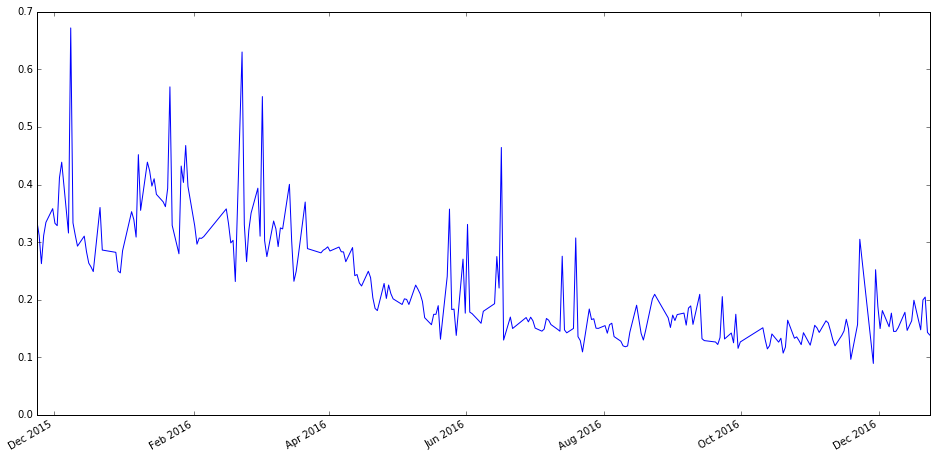

In [8]:
vol_se.plot(figsize=(16,8))

Axes(0.125,0.2;0.775x0.7)


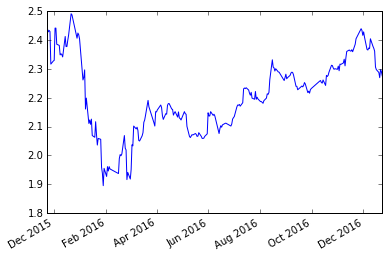

In [9]:
spot_price_se = spot_price_se.astype(float)
print spot_price_se.plot()

In [10]:
spot_price_se.to_csv("spot_price.csv")
vol_se.to_csv("vol.csv")

In [11]:
df = pd.DataFrame()
df["spot_price"] = spot_price_se
df.index = pd.DatetimeIndex(df.index).normalize()
df["etf"] = index_quotes_info["closePrice"]
print df.head(3)

            spot_price  etf
2016-12-23       2.276  NaN
2016-12-22       2.291  NaN
2016-12-21       2.298  NaN
